## Merchant chage visualizer

This notebook allows the user to pick a merchant and a month.  It will visualize the accumulation of charges for that merchant across the days of that month.

It displays three types of charges.  Graphs for each type will appear with a different color.
 - <font color='#43b02a'>(green)</font> Monthly Plan charges
 - <font color='#b0602a'>(orange)</font> App Subscription charges
 - <font color='#972ab0'>(purple)</font> App Metered events


To get started, populate the variables in the cell below.

In [56]:
#### edit these ###

db_user="testMetaRO"
db_host="localhost"
db_name="nov_meta"
merchant=194013
month=12
year=2017

###################


import MySQLdb
import calendar

db = MySQLdb.connect(user=db_user, host=db_host, db=db_name, passwd="test")

num_days = calendar.monthrange(year, month)[1]

days = range(num_days + 1)

# Holds the series data for a particular charge type
class Curve:
    def __init__(self, days_into_billing_cycle, charges_so_far):
        self.days = days_into_billing_cycle
        self.charges = charges_so_far

### Plan charges

When Clover charges a merchant for use of a plan, we do so at the beginning of the month, and in advance of the actual usage.  This means that if a merchant changes to their plan, Clover must keep track of those changes and apply them to the *following* billing cycle.



In [57]:
query = db.cursor()
query.execute(
    """
    SELECT amount, plan_charge_type                
        FROM charge                                                                 
        INNER JOIN merchant_plan_charge                                             
            ON merchant_plan_charge.charge_id = charge.id                           
    WHERE merchant_id = {}                                                      
    AND MONTH(merchant_plan_charge.created_time) = {}
    ;             
     """.format(merchant, month))

# The algorithm below is an approximation of the real adjustment algorithm
# TODO: use the real adjustment algoritm

curr_month_debits = 0
prev_month_credits = 0

for amount, charge_type in query.fetchall():
    if charge_type == 'ADJUSTMENT':
        prev_month_credits += amount;
    elif charge_type == 'ADVANCE':
        curr_month_debits += amount;
    else:
        raise ValueError("Unexpected charge type: {}".format(charge_type))

m = (curr_month_debits + prev_month_credits) / num_days

b = -prev_month_credits

# at 0 this gives the total adjustment amount from the previous month
# at <last day in month> it gives the total billed amount
# it is linear in between
def f(x):
    return m * x + b

plan = Curve(days,                                  # X values
            [round(f(x) / 100, 2) for x in days])   # Y values


#### Plan Charge Interpolation

Subscription charges and metered events occur every day, so it makes sense to view their accumulation across the days of the billing cycle.  On the other hand, Plan charges only occur once per month.  In order to view all charges on the same graph, it will be convenient if we can *pretend* that they occur daily.  Here we will inerpolate the plan charges daily.

The value on the left side represents the adjustments that they merchant is due from activity in the previous month (if any).  The value on the right side represents the total plan-related charges for that month.  If the value is zero at some point then the prorated plan charges for the current month are equal to the adjustments from the previous month.


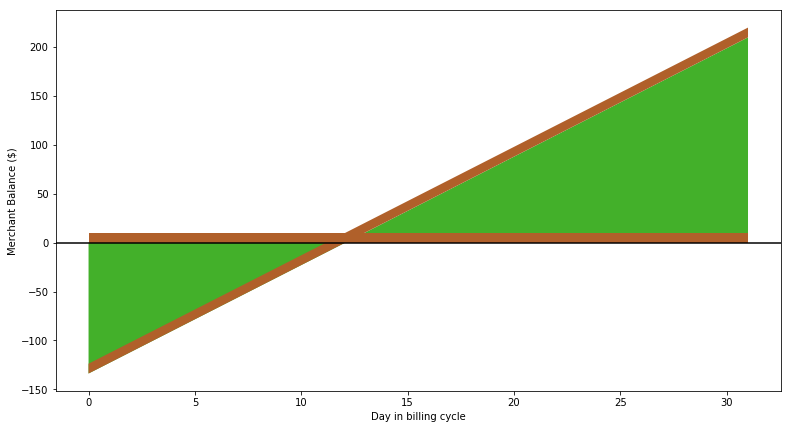

In [112]:
# library
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
# Data
x=plan.days
y=[plan.charges, [10] * (num_days + 1)]
 
# Plot
fig = plt.figure(figsize=(13,7))

plt.stackplot(x,y, labels=['Plan'], colors=['#43b02a', '#b0602a', '#972ab0'])

y=[[10] * (num_days + 1)]
plt.stackplot(x,y, labels=['Plan'], colors=['#b0602a', '#972ab0'])

plt.axhline(0, color='black')
plt.ylabel('Merchant Balance ($)')
plt.xlabel('Day in billing cycle')
#plt.legend(loc='upper left')
plt.show()

